In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import numpy as np
import os
from testLibs import *

In [4]:
with open('../data/testOutputFree/LLMsuggestions_allModels.json', 'r') as f1:
    LLMResults = json.load(f1)

with open('../data/tablesJSON/allTables_free.json', 'r') as f2:
    MznResults = json.load(f2)

In [5]:
llm_df = ResultsFlattener(LLMResults)
print('LLM DataFrame shapes and example:')
print('llm_df.shape =', llm_df.shape)
display(llm_df.head(10))

LLM DataFrame shapes and example:
llm_df.shape = (1007, 8)


,provider,model,problem,instance,top3_list,top3,top1,time_seconds
0,gemini,gemini-2.5-flash,atsp,instance4_0p15,"[or-tools_cp-sat-free, cp_optimizer-free, chuf...","or-tools_cp-sat-free, cp_optimizer-free, chuff...",or-tools_cp-sat-free,24.238
1,gemini,gemini-2.5-flash,atsp,instance20_0p35,"[or-tools_cp-sat-free, cp_optimizer-free, chuf...","or-tools_cp-sat-free, cp_optimizer-free, chuff...",or-tools_cp-sat-free,27.641
2,gemini,gemini-2.5-flash,atsp,instance14_0p25,"[cp_optimizer-free, or-tools_cp-sat-free, chuf...","cp_optimizer-free, or-tools_cp-sat-free, chuff...",cp_optimizer-free,17.376
3,gemini,gemini-2.5-flash,atsp,instance1_0p05,"[or-tools_cp-sat-free, chuffed-free, choco-sol...","or-tools_cp-sat-free, chuffed-free, choco-solv...",or-tools_cp-sat-free,20.425
4,gemini,gemini-2.5-flash,atsp,instance11_0p25,"[or-tools_cp-sat-free, cp_optimizer-free, choc...","or-tools_cp-sat-free, cp_optimizer-free, choco...",or-tools_cp-sat-free,26.904
5,gemini,gemini-2.5-flash,black-hole,layout_17,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,16.390
6,gemini,gemini-2.5-flash,black-hole,layout_25,"[cp_optimizer-free, chuffed-free, or-tools_cp-...","cp_optimizer-free, chuffed-free, or-tools_cp-s...",cp_optimizer-free,15.309
7,gemini,gemini-2.5-flash,black-hole,layout_3,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,20.054
8,gemini,gemini-2.5-flash,black-hole,layout_14,"[or-tools_cp-sat-free, cp_optimizer-free, chuf...","or-tools_cp-sat-free, cp_optimizer-free, chuff...",or-tools_cp-sat-free,22.178
9,gemini,gemini-2.5-flash,black-hole,layout_27,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,22.277


In [6]:
df = mznResultsFlattener(MznResults)
# Inspect the result
display(df.head())
print(df.shape)

out_dir = '../data/tablesCSV'
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, 'allTables_free.csv')
df.to_csv(out_path, index=False)
print(f"Saved table to {out_path}")

,Problem,Category,Instance,Solver,Status,Time,Objective,Score,Score Area
0,EchoSched,MIN,12-12-0-1_7,atlantis-free,UNK,1200000.0,NaN,0.00,1200000.00
1,EchoSched,MIN,12-12-0-1_7,cbc-free,S,1200000.0,12172.0,5.00,326862.67
2,EchoSched,MIN,12-12-0-1_7,choco-solver__cp_-free,SC,38449.0,12135.0,10.54,14001.39
3,EchoSched,MIN,12-12-0-1_7,choco-solver__cp-sat_-free,SC,48686.0,12135.0,10.03,17561.17
4,EchoSched,MIN,12-12-0-1_7,chuffed-free,SC,6508.0,12135.0,15.05,4352.61


(2000, 9)
Saved table to ../data/tablesCSV/allTables_free.csv


### Solver Score Calculation

For each solver \( s \) and instance \( i \), we compute a **score** that reflects the solver’s performance according to the rules below.  
This metric applies to both **satisfaction** and **optimization** problems.

#### Definitions

- \( sol(s, i) \): status returned by the solver  
  (possible values: `S`, `C`, `ERR`, `UNK`, `UNSAT`, etc.)
- \( val(s, i) \): objective value obtained by the solver  
- \( best(i) \): best (optimal) objective value across all solvers for that instance  
- \( worst(i) \): worst (non-error) objective value across all solvers for that instance  
- \( category(i) \): either **MIN** or **MAX**, defining whether lower or higher objectives are better  

The mapping between MiniZinc statuses and the symbolic statuses in the formula is:

| Status | Meaning | Formula Status |
|---------|----------|----------------|
| `S`, `SC` | Found a feasible solution | `SAT` |
| `C` with best objective | Optimal or proven UNSAT | `OPT` |
| `ERR` | Error or crash | `ERR` |
| `UNK` | No answer within time limit | `UNK` |



### Formula (for Minimization)

$$
score(s,i) =
\begin{cases}
0 & \text{if } sol(s,i) \in \{UNK, ERR\} \\
1 & \text{if } sol(s,i) \in \{UNSAT, OPT\} \\
0.25 + 0.5 \cdot \frac{val(s,i) - worst(i)}{best(i) - worst(i)} & \text{if } sol(s,i) = SAT
\end{cases}
$$

For **maximization problems**, the ratio in the last term is inverted.

In [7]:
# Work on a copy
scored_df = df.copy()

scored_df = scoreComputation(scored_df)
display(scored_df[scored_df['Problem'] == 'black-hole'])

# Save the table to a .csv file 
scored_df.to_csv('../data/tablesCSV/allTables_free_scored.csv', index=False)

/home/vro5/Coding/AgenticSolvers/test/notebooks/testLibs.py:109: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg = valid_objs.groupby(['Problem', 'Instance']).apply(best_worst).reset_index()


,Problem,Category,Instance,Solver,Status,Time,Objective,Score,Score Area,best,worst,DerivedStatus,ComputedScore
200,black-hole,SAT,layout_14,atlantis-free,UNK,1200000.0,NaN,0.00,1200000.0,NaN,NaN,UNK,0.0
201,black-hole,SAT,layout_14,cbc-free,UNK,1200000.0,NaN,0.00,1200000.0,NaN,NaN,UNK,0.0
202,black-hole,SAT,layout_14,choco-solver__cp_-free,S,6422.0,NaN,16.07,6422.0,NaN,NaN,OPT,1.0
203,black-hole,SAT,layout_14,choco-solver__cp-sat_-free,S,13428.0,NaN,15.03,13428.0,NaN,NaN,OPT,1.0
204,black-hole,SAT,layout_14,chuffed-free,S,687.0,NaN,19.00,687.0,NaN,NaN,OPT,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,black-hole,SAT,layout_3,picatsat-free,S,39746.0,NaN,13.00,39746.0,NaN,NaN,OPT,1.0
296,black-hole,SAT,layout_3,pumpkin-free,UNK,1200000.0,NaN,0.00,1200000.0,NaN,NaN,UNK,0.0
297,black-hole,SAT,layout_3,scip-free,UNK,1200000.0,NaN,0.00,1200000.0,NaN,NaN,UNK,0.0
298,black-hole,SAT,layout_3,sicstus_prolog-free,UNK,1200000.0,NaN,0.00,1200000.0,NaN,NaN,UNK,0.0


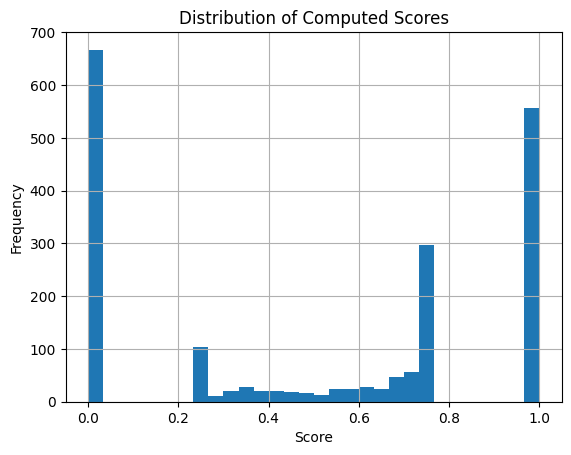

In [8]:
# We verify scores by plotting their distribution

scored_df['ComputedScore'].hist(bins=30)
plt.title('Distribution of Computed Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

In [9]:
llm_summary = compute_llm_scores(llm_df, scored_df)

display(llm_summary.sort_values('LLM_AvgScore', ascending=False))

# Save the LLM summary to a .csv file and create directory if not exists
os.makedirs('../data/DFs/top3Scored', exist_ok=True)
llm_summary.to_csv('../data/DFs/top3Scored/llm_AllModels.csv', index=False)

,provider,model,LLM_TotalScore,InstancesCovered,LLM_AvgScore
8,groq,llama-3.3-70b-versatile,9.496286,10,0.949629
5,groq,groq/compound,8.246286,9,0.916254
9,groq,meta-llama/llama-4-maverick-17b-128e-instruct,63.548809,72,0.882622
13,groq,moonshotai/kimi-k2-instruct-0905,66.186425,75,0.882486
12,groq,moonshotai/kimi-k2-instruct,65.816023,75,0.877547
14,groq,openai/gpt-oss-120b,64.508145,74,0.871732
6,groq,groq/compound-mini,29.623209,35,0.846377
15,groq,openai/gpt-oss-20b,63.328830,75,0.844384
10,groq,meta-llama/llama-4-scout-17b-16e-instruct,57.814521,69,0.837892
3,gemini,gemini-2.5-pro,41.594014,51,0.815569


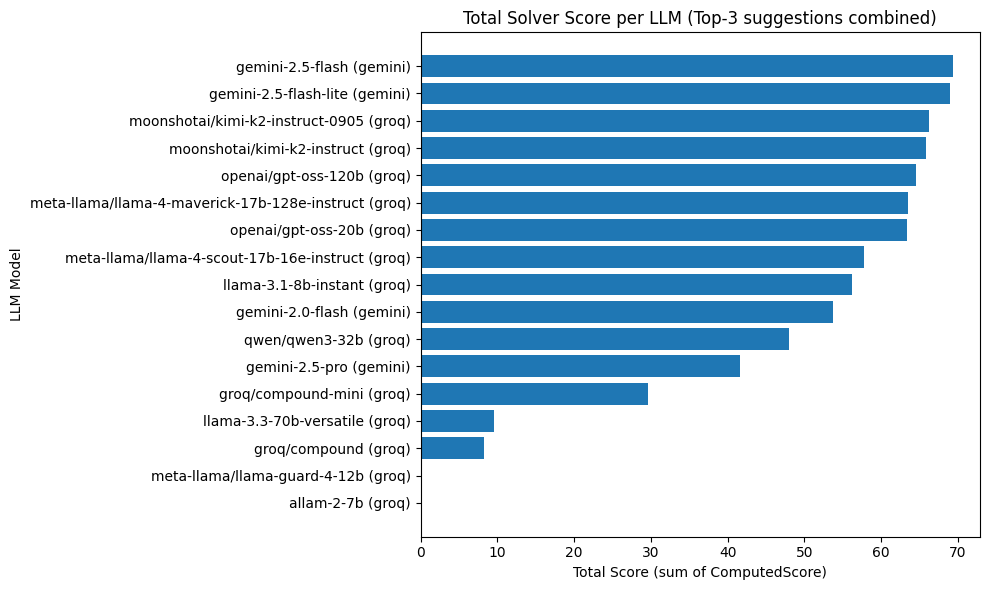

In [10]:
# Sort by total score
plot_df = llm_summary.sort_values('LLM_TotalScore', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(
    plot_df['model'] + " (" + plot_df['provider'] + ")", 
    plot_df['LLM_TotalScore']
)
plt.title("Total Solver Score per LLM (Top-3 suggestions combined)")
plt.xlabel("Total Score (sum of ComputedScore)")
plt.ylabel("LLM Model")
plt.tight_layout()
plt.show()

In [11]:
llm_top1_summary, llm_top1_scored = compute_top1_llm_scores(llm_df, scored_df)
display(llm_top1_summary)

# Save the Top-1 LLM summary to a .csv file
os.makedirs('../data/DFs/top1Scored', exist_ok=True)
llm_top1_summary.to_csv('../data/DFs/top1Scored/llm_AllModels.csv', index=False)


,provider,model,LLM_Top1_TotalScore,LLM_Top1_AvgScore,InstancesCovered
2,gemini,gemini-2.5-flash-lite,64.363418,0.794610,85
1,gemini,gemini-2.5-flash,60.962014,0.734482,85
12,groq,moonshotai/kimi-k2-instruct-0905,59.680205,0.817537,75
11,groq,moonshotai/kimi-k2-instruct,58.609073,0.837272,75
13,groq,openai/gpt-oss-120b,58.166305,0.796799,74
14,groq,openai/gpt-oss-20b,57.154105,0.828320,75
9,groq,meta-llama/llama-4-maverick-17b-128e-instruct,56.297161,0.804245,72
10,groq,meta-llama/llama-4-scout-17b-16e-instruct,54.305367,0.798608,69
0,gemini,gemini-2.0-flash,43.412659,0.700204,67
15,groq,qwen/qwen3-32b,42.116501,0.779935,65


In [12]:
# Extract missing instances for a specific LLM model
model_to_check = 'gemini-2.5-flash'
llm_model_data = llm_top1_scored[llm_top1_scored['model'] == model_to_check]
# find all (problem, instance) pairs in scored_df, then remove those covered by this LLM model
scored_pairs = (
    scored_df[['Problem', 'Instance']]
    .drop_duplicates()
    .rename(columns={'Problem': 'problem', 'Instance': 'instance'})
    .astype(str)
)

covered_pairs = llm_model_data[['problem', 'instance']].drop_duplicates().astype(str)

missing_instances = (
    scored_pairs.merge(covered_pairs, on=['problem', 'instance'], how='left', indicator=True)
    .query("_merge == 'left_only'")
    .drop(columns=['_merge'])
    .reset_index(drop=True)
)
print(f"Missing instances for model '{model_to_check}':")
display(missing_instances)

Missing instances for model 'gemini-2.5-flash':


,problem,instance
0,groupsplitter,u12g2pref0
1,groupsplitter,u12g2pref2
2,groupsplitter,u15g1pref2
3,groupsplitter,u15g3pref0
4,groupsplitter,u15g5pref1
5,hitori,h11-1
6,proteindesign12,1HZ5.12p.19aa.usingEref_self
7,proteindesign12,1HZ5.12p.9aa.usingEref_self
8,proteindesign12,1UBI.13p.19aa.usingEref_self
9,proteindesign12,1UBI.13p.9aa.usingEref_self_x


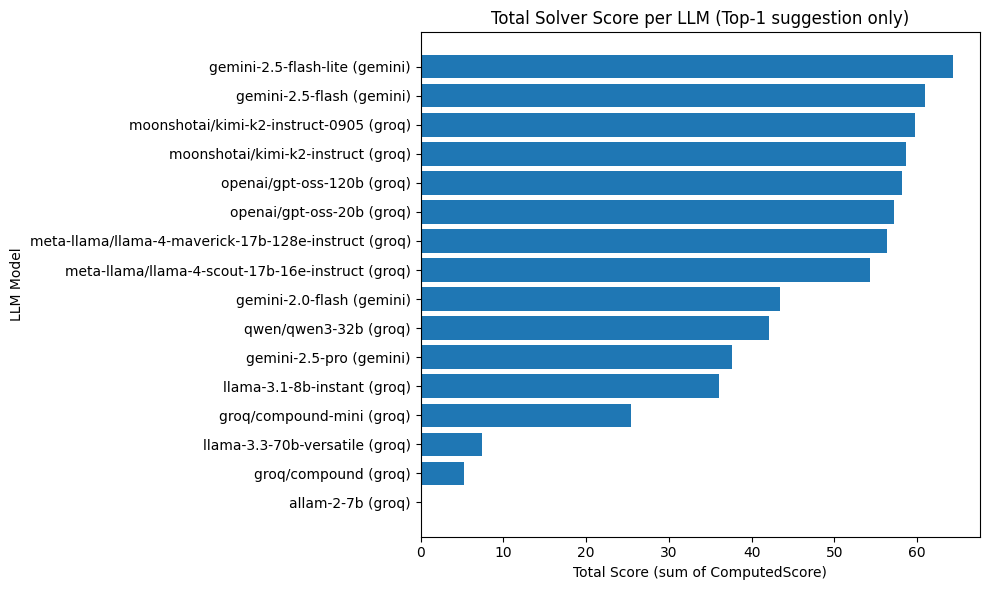

In [13]:
# Sort by total score
plot_df = llm_top1_summary.sort_values('LLM_Top1_TotalScore', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(
    plot_df['model'] + " (" + plot_df['provider'] + ")", 
    plot_df['LLM_Top1_TotalScore']
)
plt.title("Total Solver Score per LLM (Top-1 suggestion only)")
plt.xlabel("Total Score (sum of ComputedScore)")
plt.ylabel("LLM Model")
plt.tight_layout()
plt.show()

### Closed-Gap (CG) Metric Calculation

The **closed-gap (cg)** metric measures how close a solver selection (in this case, the LLM’s chosen solver) is to the *Virtual Best Solver* (VBS), normalized against the *Single Best Solver* (SBS).

#### Formula

$$
cg = \frac{score_{all}(AS) - score_{all}(SBS)}{score_{all}(VBS) - score_{all}(SBS)}
$$

where:
- **AS** = Algorithm Selector (the solver predicted by the LLM)
- **VBS** = Virtual Best Solver — the solver that achieves the best score on each instance
- **SBS** = Single Best Solver — the single solver that performs best overall across the dataset  
  (in our case: `SBS = 'or-tools_cp-sat-free'`)

In [14]:


cg_results = compute_closed_gap(llm_top1_scored, scored_df)

cg_df = pd.DataFrame(cg_results).sort_values('ClosedGap', ascending=False)
display(cg_df)

# Save the Closed Gap results to a .csv file
os.makedirs('../data/DFs/closedGap', exist_ok=True)
cg_df.to_csv('../data/DFs/closedGap/llm_AllModels.csv', index=False)

,provider,model,InstancesCovered,AS,SBS,VBS,ClosedGap
2,gemini,gemini-2.5-flash-lite,85,64.363418,65.750486,74.50,-0.158531
3,gemini,gemini-2.5-pro,51,37.640862,38.701589,45.00,-0.168412
12,groq,moonshotai/kimi-k2-instruct-0905,75,59.680205,62.421154,68.50,-0.450900
1,gemini,gemini-2.5-flash,85,60.962014,65.750486,74.50,-0.547284
11,groq,moonshotai/kimi-k2-instruct,75,58.609073,62.421154,68.50,-0.627106
10,groq,meta-llama/llama-4-scout-17b-16e-instruct,69,54.305367,57.646619,62.75,-0.654713
13,groq,openai/gpt-oss-120b,74,58.166305,61.956559,67.50,-0.683737
9,groq,meta-llama/llama-4-maverick-17b-128e-instruct,72,56.297161,60.536429,65.50,-0.854076
14,groq,openai/gpt-oss-20b,75,57.154105,62.421154,68.50,-0.866455
0,gemini,gemini-2.0-flash,67,43.412659,52.032047,60.25,-1.048849


## General classification of single solvers based on score

In [15]:
score_solvers_df = singleSolverScore(scored_df)
display(score_solvers_df)

# Save the single solver scores to a .csv file
score_solvers_df.to_csv('../data/DFs/solverComparison/solverScores_free.csv', index=False)

score_solvers_df.drop(columns='NumOptimal', inplace=True)


,Solver,TotalScore,NumOptimal
13,or-tools_cp-sat-free,76.964375,55
15,picatsat-free,70.933307,53
4,chuffed-free,74.456334,52
10,huub-free,68.497987,48
8,gurobi-free,55.384518,38
16,pumpkin-free,58.543229,33
2,choco-solver__cp-sat_-free,60.808176,32
6,cplex-free,48.514529,30
3,choco-solver__cp_-free,58.404323,29
7,gecode-fd,50.073443,26


## Confrontation between single solvers and LLMs 
### extraction of the five best models which will be the only one considered from now on

In [16]:
# We put together both solver total score and LLM total score, to see how LLMs compare to single solvers
llm_totscores = llm_top1_summary.copy()

# Rename LLM_Top1_TotalScore to TotalScore and model to Solver
llm_totscores = llm_totscores.rename(columns={'LLM_Top1_TotalScore':'TotalScore', 'model': 'Solver'})
# We drop LLM_Top1_AvgScore	InstancesCovered and provider columns
llm_totscores = llm_totscores.drop(columns=['LLM_Top1_AvgScore', 'InstancesCovered', 'provider'])

frames = [llm_totscores, score_solvers_df]
generalScores = pd.concat(frames)

generalScores_df = pd.DataFrame(generalScores).sort_values('TotalScore', ascending=False)
display(generalScores_df) 
display(llm_totscores)

solver_list = llm_totscores['Solver'].head().astype(str).tolist()
print('==== Top 5 LLM Solvers ====')
print(solver_list)

# Save the general scores DataFrame to CSV
os.makedirs('../data/DFs/solverComparison', exist_ok=True)
generalScores_df.to_csv('../data/DFs/solverComparison/generalScores_allLLMs.csv', index=False)

,Solver,TotalScore
13,or-tools_cp-sat-free,76.964375
4,chuffed-free,74.456334
15,picatsat-free,70.933307
10,huub-free,68.497987
2,gemini-2.5-flash-lite,64.363418
1,gemini-2.5-flash,60.962014
2,choco-solver__cp-sat_-free,60.808176
12,moonshotai/kimi-k2-instruct-0905,59.680205
11,izplus-free,58.672093
11,moonshotai/kimi-k2-instruct,58.609073


,Solver,TotalScore
2,gemini-2.5-flash-lite,64.363418
1,gemini-2.5-flash,60.962014
12,moonshotai/kimi-k2-instruct-0905,59.680205
11,moonshotai/kimi-k2-instruct,58.609073
13,openai/gpt-oss-120b,58.166305
14,openai/gpt-oss-20b,57.154105
9,meta-llama/llama-4-maverick-17b-128e-instruct,56.297161
10,meta-llama/llama-4-scout-17b-16e-instruct,54.305367
0,gemini-2.0-flash,43.412659
15,qwen/qwen3-32b,42.116501


==== Top 5 LLM Solvers ====
['gemini-2.5-flash-lite', 'gemini-2.5-flash', 'moonshotai/kimi-k2-instruct-0905', 'moonshotai/kimi-k2-instruct', 'openai/gpt-oss-120b']


# Top Models
### From now on we'll only bve using the yop 5 performing models:
'gemini-2.5-flash-lite', 'gemini-2.5-flash', 'moonshotai/kimi-k2-instruct', 'moonshotai/kimi-k2-instruct-0905', 'openai/gpt-oss-120b'
Data aquired from those LLMs where reached via truncation of input problems to keep request within each LLM's rate limits.
### Performed tests
We'll be comparing results from 4 different setups:
- Base instances simply 
- Problem Description
- Solver's description
- Both descriptions
  
Given that last 2 setups had too long descriptions to be put in single requests, those test were made in a "chat-like" setup

In [17]:
with open('../data/testOutputFree/LLMsuggestions_base.json', 'r') as f3:
    LLMResultsTop = json.load(f3)

with open('../data/testOutputFree/LLMsuggestions_pDesc.json', 'r') as f4:
    LLMResultsTopDesc = json.load(f4)

with open('../data/testOutputFree/LLMsuggestions_sDesc.json', 'r') as f5:
    LLMResultsTopSDesc = json.load(f5)

with open('../data/testOutputFree/LLMsuggestions_sDesc_pDesc.json', 'r') as f6:
    LLMResultsTopSDPD = json.load(f6)

In [18]:
# --- Flatten different LLMResults variants ---

llmT_df = ResultsFlattener(LLMResultsTop)
print('Top LLM DataFrame shapes and example:')
print('llmT_df.shape =', llmT_df.shape)
display(llmT_df.head(10))

llmTD_df = ResultsFlattener(LLMResultsTopDesc)
print('Top+Desc LLM DataFrame shapes and example:')
print('llmTD_df.shape =', llmTD_df.shape)
display(llmTD_df.head(10))

llmTSD_df = ResultsFlattener(LLMResultsTopSDesc)
print('Top+SDesc LLM DataFrame shapes and example:')
print('llmTSD_df.shape =', llmTSD_df.shape)
display(llmTSD_df.head(10))

llmTSDPD_df = ResultsFlattener(LLMResultsTopSDPD)
print('Top+SDesc+PDesc LLM DataFrame shapes and example:')
print('llmTSDPD_df.shape =', llmTSDPD_df.shape)
display(llmTSDPD_df.head(10))

# Now we merge all the DataFrames together, by Adding a column 'LLMvariant' to distinguish them
llmT_df['LLMvariant'] = 'Top'
llmTD_df['LLMvariant'] = 'Top+Desc'
llmTSD_df['LLMvariant'] = 'Top+SDesc'
llmTSDPD_df['LLMvariant'] = 'Top+SDesc+PDesc'

all_llm_df = pd.concat([llmT_df, llmTD_df, llmTSD_df, llmTSDPD_df], ignore_index=True)
print('All LLM variants combined DataFrame shape and example:')
print('all_llm_df.shape =', all_llm_df.shape)
display(all_llm_df.head(10))

Top LLM DataFrame shapes and example:
llmT_df.shape = (500, 8)


,provider,model,problem,instance,top3_list,top3,top1,time_seconds
0,gemini,gemini-2.5-flash-lite,atsp,instance14_0p25,"[or-tools_cp-sat-free, choco-solver__cp-sat_-f...","or-tools_cp-sat-free, choco-solver__cp-sat_-fr...",or-tools_cp-sat-free,2.176
1,gemini,gemini-2.5-flash-lite,atsp,instance11_0p25,"[or-tools_cp-sat-free, choco-solver__cp_-free,...","or-tools_cp-sat-free, choco-solver__cp_-free, ...",or-tools_cp-sat-free,1.853
2,gemini,gemini-2.5-flash-lite,atsp,instance1_0p05,"[or-tools_cp-sat-free, cp_optimizer-free, choc...","or-tools_cp-sat-free, cp_optimizer-free, choco...",or-tools_cp-sat-free,1.448
3,gemini,gemini-2.5-flash-lite,atsp,instance4_0p15,"[or-tools_cp-sat-free, choco-solver__cp_-free,...","or-tools_cp-sat-free, choco-solver__cp_-free, ...",or-tools_cp-sat-free,1.934
4,gemini,gemini-2.5-flash-lite,atsp,instance20_0p35,"[or-tools_cp-sat-free, chuffed-free, choco-sol...","or-tools_cp-sat-free, chuffed-free, choco-solv...",or-tools_cp-sat-free,4.900
5,gemini,gemini-2.5-flash-lite,black-hole,layout_14,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,10.943
6,gemini,gemini-2.5-flash-lite,black-hole,layout_27,"[choco-solver__cp_-free, chuffed-free, or-tool...","choco-solver__cp_-free, chuffed-free, or-tools...",choco-solver__cp_-free,1.392
7,gemini,gemini-2.5-flash-lite,black-hole,layout_17,"[choco-solver__cp_-par, chuffed-free, or-tools...","choco-solver__cp_-par, chuffed-free, or-tools_...",choco-solver__cp_-par,1.245
8,gemini,gemini-2.5-flash-lite,black-hole,layout_25,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,1.827
9,gemini,gemini-2.5-flash-lite,black-hole,layout_3,"[or-tools_cp-sat-free, choco-solver__cp_-par, ...","or-tools_cp-sat-free, choco-solver__cp_-par, c...",or-tools_cp-sat-free,1.021


Top+Desc LLM DataFrame shapes and example:
llmTD_df.shape = (475, 8)


,provider,model,problem,instance,top3_list,top3,top1,time_seconds
0,groq,moonshotai/kimi-k2-instruct-0905,atsp,instance14_0p25,"[or-tools_cp-sat-free, chuffed-free, choco-sol...","or-tools_cp-sat-free, chuffed-free, choco-solv...",or-tools_cp-sat-free,2.941
1,groq,moonshotai/kimi-k2-instruct-0905,atsp,instance11_0p25,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,0.468
2,groq,moonshotai/kimi-k2-instruct-0905,atsp,instance1_0p05,"[chuffed-free, or-tools_cp-sat-free, cp_optimi...","chuffed-free, or-tools_cp-sat-free, cp_optimiz...",chuffed-free,0.398
3,groq,moonshotai/kimi-k2-instruct-0905,atsp,instance4_0p15,"[chuffed-free, or-tools_cp-sat-free, choco-sol...","chuffed-free, or-tools_cp-sat-free, choco-solv...",chuffed-free,0.923
4,groq,moonshotai/kimi-k2-instruct-0905,atsp,instance20_0p35,"[or-tools_cp-sat-free, choco-solver__cp-sat_-f...","or-tools_cp-sat-free, choco-solver__cp-sat_-fr...",or-tools_cp-sat-free,0.585
5,groq,moonshotai/kimi-k2-instruct-0905,black-hole,layout_14,"[chuffed-free, or-tools_cp-sat-free, huub-free]","chuffed-free, or-tools_cp-sat-free, huub-free",chuffed-free,0.454
6,groq,moonshotai/kimi-k2-instruct-0905,black-hole,layout_27,"[chuffed-free, or-tools_cp-sat-free, jacop-free]","chuffed-free, or-tools_cp-sat-free, jacop-free",chuffed-free,0.640
7,groq,moonshotai/kimi-k2-instruct-0905,black-hole,layout_17,"[chuffed-free, or-tools_cp-sat-free, jacop-free]","chuffed-free, or-tools_cp-sat-free, jacop-free",chuffed-free,0.669
8,groq,moonshotai/kimi-k2-instruct-0905,black-hole,layout_25,"[chuffed-free, or-tools_cp-sat-free, gurobi-free]","chuffed-free, or-tools_cp-sat-free, gurobi-free",chuffed-free,0.652
9,groq,moonshotai/kimi-k2-instruct-0905,black-hole,layout_3,"[chuffed-free, or-tools_cp-sat-free, gurobi-free]","chuffed-free, or-tools_cp-sat-free, gurobi-free",chuffed-free,0.728


Top+SDesc LLM DataFrame shapes and example:
llmTSD_df.shape = (500, 8)


,provider,model,problem,instance,top3_list,top3,top1,time_seconds
0,chat,gemini-2.5-flash-lite,atsp,instance11_0p25,"[atlantis-free, cbc-free, choco-solver__cp_-free]","atlantis-free, cbc-free, choco-solver__cp_-free",atlantis-free,NaN
1,chat,gemini-2.5-flash-lite,atsp,instance14_0p25,"[atlantis-free, cbc-free, choco-solver__cp_-free]","atlantis-free, cbc-free, choco-solver__cp_-free",atlantis-free,NaN
2,chat,gemini-2.5-flash-lite,atsp,instance1_0p05,"[atlantis-free, cbc-free, choco-solver__cp_-free]","atlantis-free, cbc-free, choco-solver__cp_-free",atlantis-free,NaN
3,chat,gemini-2.5-flash-lite,atsp,instance20_0p35,"[atlantis-free, cbc-free, choco-solver__cp_-free]","atlantis-free, cbc-free, choco-solver__cp_-free",atlantis-free,NaN
4,chat,gemini-2.5-flash-lite,atsp,instance4_0p15,"[atlantis-free, cbc-free, choco-solver__cp_-free]","atlantis-free, cbc-free, choco-solver__cp_-free",atlantis-free,NaN
5,chat,gemini-2.5-flash-lite,black-hole,layout_14,"[choco-solver__cp_-free, cp_optimizer-free, or...","choco-solver__cp_-free, cp_optimizer-free, or-...",choco-solver__cp_-free,NaN
6,chat,gemini-2.5-flash-lite,black-hole,layout_17,"[choco-solver__cp_-free, cp_optimizer-free, or...","choco-solver__cp_-free, cp_optimizer-free, or-...",choco-solver__cp_-free,NaN
7,chat,gemini-2.5-flash-lite,black-hole,layout_25,"[choco-solver__cp_-free, cp_optimizer-free, or...","choco-solver__cp_-free, cp_optimizer-free, or-...",choco-solver__cp_-free,NaN
8,chat,gemini-2.5-flash-lite,black-hole,layout_27,"[choco-solver__cp_-free, cp_optimizer-free, or...","choco-solver__cp_-free, cp_optimizer-free, or-...",choco-solver__cp_-free,NaN
9,chat,gemini-2.5-flash-lite,black-hole,layout_3,"[choco-solver__cp_-free, cp_optimizer-free, or...","choco-solver__cp_-free, cp_optimizer-free, or-...",choco-solver__cp_-free,NaN


Top+SDesc+PDesc LLM DataFrame shapes and example:
llmTSDPD_df.shape = (499, 8)


,provider,model,problem,instance,top3_list,top3,top1,time_seconds
0,chat,gemini-2.5-flash-lite,atsp,instance11_0p25,"[choco-solver__cp_-free, cp_optimizer-free, gu...","choco-solver__cp_-free, cp_optimizer-free, gur...",choco-solver__cp_-free,NaN
1,chat,gemini-2.5-flash-lite,atsp,instance14_0p25,"[choco-solver__cp_-free, cp_optimizer-free, gu...","choco-solver__cp_-free, cp_optimizer-free, gur...",choco-solver__cp_-free,NaN
2,chat,gemini-2.5-flash-lite,atsp,instance1_0p05,"[choco-solver__cp_-free, cp_optimizer-free, gu...","choco-solver__cp_-free, cp_optimizer-free, gur...",choco-solver__cp_-free,NaN
3,chat,gemini-2.5-flash-lite,atsp,instance20_0p35,"[choco-solver__cp_-free, cp_optimizer-free, gu...","choco-solver__cp_-free, cp_optimizer-free, gur...",choco-solver__cp_-free,NaN
4,chat,gemini-2.5-flash-lite,atsp,instance4_0p15,"[choco-solver__cp_-free, cp_optimizer-free, gu...","choco-solver__cp_-free, cp_optimizer-free, gur...",choco-solver__cp_-free,NaN
5,chat,gemini-2.5-flash-lite,black-hole,layout_14,"[choco-solver__cp_-free, chuffed-free, or-tool...","choco-solver__cp_-free, chuffed-free, or-tools...",choco-solver__cp_-free,NaN
6,chat,gemini-2.5-flash-lite,black-hole,layout_17,"[choco-solver__cp_-free, chuffed-free, or-tool...","choco-solver__cp_-free, chuffed-free, or-tools...",choco-solver__cp_-free,NaN
7,chat,gemini-2.5-flash-lite,black-hole,layout_25,"[choco-solver__cp_-free, chuffed-free, or-tool...","choco-solver__cp_-free, chuffed-free, or-tools...",choco-solver__cp_-free,NaN
8,chat,gemini-2.5-flash-lite,black-hole,layout_27,"[choco-solver__cp_-free, chuffed-free, or-tool...","choco-solver__cp_-free, chuffed-free, or-tools...",choco-solver__cp_-free,NaN
9,chat,gemini-2.5-flash-lite,black-hole,layout_3,"[choco-solver__cp_-free, chuffed-free, or-tool...","choco-solver__cp_-free, chuffed-free, or-tools...",choco-solver__cp_-free,NaN


All LLM variants combined DataFrame shape and example:
all_llm_df.shape = (1974, 9)


,provider,model,problem,instance,top3_list,top3,top1,time_seconds,LLMvariant
0,gemini,gemini-2.5-flash-lite,atsp,instance14_0p25,"[or-tools_cp-sat-free, choco-solver__cp-sat_-f...","or-tools_cp-sat-free, choco-solver__cp-sat_-fr...",or-tools_cp-sat-free,2.176,Top
1,gemini,gemini-2.5-flash-lite,atsp,instance11_0p25,"[or-tools_cp-sat-free, choco-solver__cp_-free,...","or-tools_cp-sat-free, choco-solver__cp_-free, ...",or-tools_cp-sat-free,1.853,Top
2,gemini,gemini-2.5-flash-lite,atsp,instance1_0p05,"[or-tools_cp-sat-free, cp_optimizer-free, choc...","or-tools_cp-sat-free, cp_optimizer-free, choco...",or-tools_cp-sat-free,1.448,Top
3,gemini,gemini-2.5-flash-lite,atsp,instance4_0p15,"[or-tools_cp-sat-free, choco-solver__cp_-free,...","or-tools_cp-sat-free, choco-solver__cp_-free, ...",or-tools_cp-sat-free,1.934,Top
4,gemini,gemini-2.5-flash-lite,atsp,instance20_0p35,"[or-tools_cp-sat-free, chuffed-free, choco-sol...","or-tools_cp-sat-free, chuffed-free, choco-solv...",or-tools_cp-sat-free,4.900,Top
5,gemini,gemini-2.5-flash-lite,black-hole,layout_14,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,10.943,Top
6,gemini,gemini-2.5-flash-lite,black-hole,layout_27,"[choco-solver__cp_-free, chuffed-free, or-tool...","choco-solver__cp_-free, chuffed-free, or-tools...",choco-solver__cp_-free,1.392,Top
7,gemini,gemini-2.5-flash-lite,black-hole,layout_17,"[choco-solver__cp_-par, chuffed-free, or-tools...","choco-solver__cp_-par, chuffed-free, or-tools_...",choco-solver__cp_-par,1.245,Top
8,gemini,gemini-2.5-flash-lite,black-hole,layout_25,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,1.827,Top
9,gemini,gemini-2.5-flash-lite,black-hole,layout_3,"[or-tools_cp-sat-free, choco-solver__cp_-par, ...","or-tools_cp-sat-free, choco-solver__cp_-par, c...",or-tools_cp-sat-free,1.021,Top


In [19]:
# --- Compute scores for different LLMResults variants ---
llmT_summary = compute_llm_scores(llmT_df, scored_df)
print('Top LLM Summary:')
display(llmT_summary.sort_values('LLM_TotalScore', ascending=False))

llmTD_summary = compute_llm_scores(llmTD_df, scored_df)
print('Top+Desc LLM Summary:')
display(llmTD_summary.sort_values('LLM_TotalScore', ascending=False))
llmTSD_summary = compute_llm_scores(llmTSD_df, scored_df)
print('Top+SDesc LLM Summary:')
display(llmTSD_summary.sort_values('LLM_TotalScore', ascending=False))

llmTSDPD_summary = compute_llm_scores(llmTSDPD_df, scored_df)
print('Top+SDesc+PDesc LLM Summary:')
display(llmTSDPD_summary.sort_values('LLM_TotalScore', ascending=False))

# --- Save all LLM scored variants  DataFrame to CSV ---
llmT_summary.to_csv('../data/DFs/top3Scored/llm_Base.csv', index=False)
llmTD_summary.to_csv('../data/DFs/top3Scored/llm_Desc.csv', index=False)
llmTSD_summary.to_csv('../data/DFs/top3Scored/llm_SDesc.csv', index=False)
llmTSDPD_summary.to_csv('../data/DFs/top3Scored/llm_SDescPDesc.csv', index=False)

Top LLM Summary:


,provider,model,LLM_TotalScore,InstancesCovered,LLM_AvgScore
2,groq,moonshotai/kimi-k2-instruct,83.268350,100,0.832684
3,groq,moonshotai/kimi-k2-instruct-0905,82.656808,100,0.826568
4,groq,openai/gpt-oss-120b,82.226540,100,0.822265
1,gemini,gemini-2.5-flash-lite,80.740964,100,0.807410
0,gemini,gemini-2.5-flash,79.105374,100,0.791054


Top+Desc LLM Summary:


,provider,model,LLM_TotalScore,InstancesCovered,LLM_AvgScore
4,groq,openai/gpt-oss-120b,83.249694,100,0.832497
3,groq,moonshotai/kimi-k2-instruct-0905,83.182120,100,0.831821
1,gemini,gemini-2.5-flash-lite,82.620972,100,0.826210
2,groq,moonshotai/kimi-k2-instruct,81.889913,100,0.818899
0,gemini,gemini-2.5-flash,59.154157,75,0.788722


Top+SDesc LLM Summary:


,provider,model,LLM_TotalScore,InstancesCovered,LLM_AvgScore
0,chat,gemini-2.5-flash,83.137340,100,0.831373
3,chat,moonshotai/kimi-k2-instruct-0905,82.488843,100,0.824888
2,chat,moonshotai/kimi-k2-instruct,82.236482,100,0.822365
4,chat,openai/gpt-oss-120b,78.799796,100,0.787998
1,chat,gemini-2.5-flash-lite,77.746753,100,0.777468


Top+SDesc+PDesc LLM Summary:


,provider,model,LLM_TotalScore,InstancesCovered,LLM_AvgScore
0,chat,gemini-2.5-flash,83.650662,100,0.836507
3,chat,moonshotai/kimi-k2-instruct-0905,82.218875,100,0.822189
2,chat,moonshotai/kimi-k2-instruct,80.417378,99,0.812297
4,chat,openai/gpt-oss-120b,80.295619,100,0.802956
1,chat,gemini-2.5-flash-lite,78.147548,100,0.781475


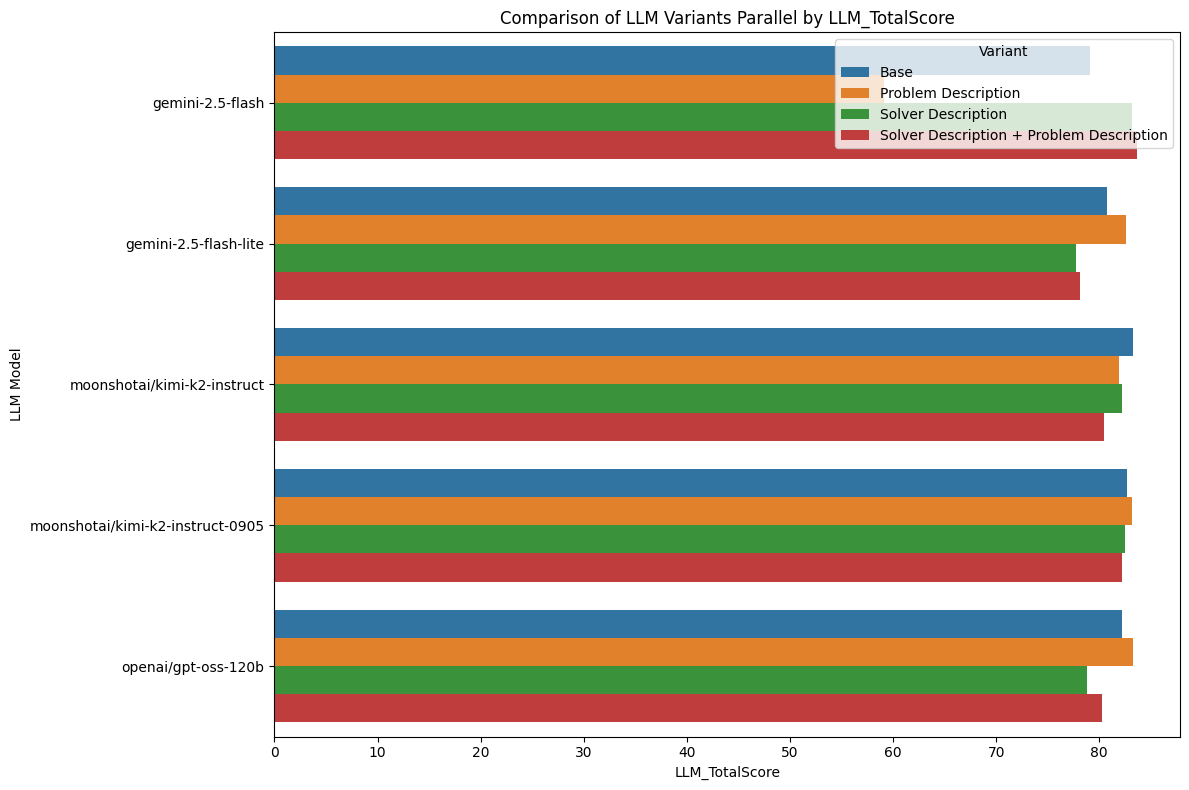

In [20]:
plot_llm_variant_comparison(
    [llmT_summary, llmTD_summary, llmTSD_summary, llmTSDPD_summary],
    ['Base', 'Problem Description', 'Solver Description', 'Solver Description + Problem Description'],
    'LLM_TotalScore'
)

In [21]:
with open('../data/tablesJSON/allTables_open.json', 'r') as f7:
    MznResultsOpen = json.load(f7)

df_open = mznResultsFlattener(MznResultsOpen)
# Inspect the result
display(df_open.head())

,Problem,Category,Instance,Solver,Status,Time,Objective,Score,Score Area
0,EchoSched,MIN,12-12-0-1_7,atlantis-free,UNK,1200000.0,NaN,0.00,1200000.00
1,EchoSched,MIN,12-12-0-1_7,cbc-par,S,1200000.0,12138.0,6.00,317587.42
2,EchoSched,MIN,12-12-0-1_7,choco-solver__cp_-par,SC,23934.0,12135.0,12.83,20153.98
3,EchoSched,MIN,12-12-0-1_7,choco-solver__cp-sat_-par,SC,21290.0,12135.0,13.05,13682.73
4,EchoSched,MIN,12-12-0-1_7,chuffed-free,SC,6508.0,12135.0,16.02,4352.61


In [22]:
# Work on a copy
scored_df_open = df_open.copy()

scored_df_open = scoreComputation(scored_df_open)
display(scored_df_open.head())


/home/vro5/Coding/AgenticSolvers/test/notebooks/testLibs.py:109: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg = valid_objs.groupby(['Problem', 'Instance']).apply(best_worst).reset_index()


,Problem,Category,Instance,Solver,Status,Time,Objective,Score,Score Area,best,worst,DerivedStatus,ComputedScore
0,EchoSched,MIN,12-12-0-1_7,atlantis-free,UNK,1200000.0,NaN,0.00,1200000.00,12135.0,12213.0,UNK,0.000000
1,EchoSched,MIN,12-12-0-1_7,cbc-par,S,1200000.0,12138.0,6.00,317587.42,12135.0,12213.0,SAT,0.730769
2,EchoSched,MIN,12-12-0-1_7,choco-solver__cp_-par,SC,23934.0,12135.0,12.83,20153.98,12135.0,12213.0,OPT,1.000000
3,EchoSched,MIN,12-12-0-1_7,choco-solver__cp-sat_-par,SC,21290.0,12135.0,13.05,13682.73,12135.0,12213.0,OPT,1.000000
4,EchoSched,MIN,12-12-0-1_7,chuffed-free,SC,6508.0,12135.0,16.02,4352.61,12135.0,12213.0,OPT,1.000000


In [23]:
# Now we merge LLMvariants 
llmT_summary['LLMvariant'] = 'Top'
llmTD_summary['LLMvariant'] = 'Top+Desc'
llmTSD_summary['LLMvariant'] = 'Top+SDesc'
llmTSDPD_summary['LLMvariant'] = 'Top+SDesc+PDesc'
llm_variants_summary = pd.concat([llmT_summary, llmTD_summary, llmTSD_summary, llmTSDPD_summary], ignore_index=True)

# We create a column to put together model and LLMvariant
llm_variants_summary['Model_Variant'] = llm_variants_summary['model'] + ' (' + llm_variants_summary['LLMvariant'] + ')'
# We drop rows with InstancesCovered < 100
llm_variants_summary = llm_variants_summary[llm_variants_summary['InstancesCovered'] >= 100]
# We drop useless columns
llm_variants_summary = llm_variants_summary.drop(columns=['provider', 'InstancesCovered', 'model', 'LLMvariant', 'LLM_AvgScore'])
display(llm_variants_summary.sort_values('LLM_TotalScore', ascending=False))

,LLM_TotalScore,Model_Variant
15,83.650662,gemini-2.5-flash (Top+SDesc+PDesc)
2,83.268350,moonshotai/kimi-k2-instruct (Top)
9,83.249694,openai/gpt-oss-120b (Top+Desc)
8,83.182120,moonshotai/kimi-k2-instruct-0905 (Top+Desc)
10,83.137340,gemini-2.5-flash (Top+SDesc)
3,82.656808,moonshotai/kimi-k2-instruct-0905 (Top)
6,82.620972,gemini-2.5-flash-lite (Top+Desc)
13,82.488843,moonshotai/kimi-k2-instruct-0905 (Top+SDesc)
12,82.236482,moonshotai/kimi-k2-instruct (Top+SDesc)
4,82.226540,openai/gpt-oss-120b (Top)


In [24]:
open_solver_scores = singleSolverScore(scored_df_open)
display(open_solver_scores)
# Save open solver scores to CSV
os.makedirs('../data/DFs/solverComparison', exist_ok=True)
open_solver_scores.to_csv('../data/DFs/solverComparison/solverScores_Open.csv', index=False)

open_solver_scores.drop(columns='NumOptimal', inplace=True)

,Solver,TotalScore,NumOptimal
14,or-tools_cp-sat-par,88.117745,72
16,picatsat-free,70.647879,53
4,chuffed-free,74.819831,52
11,huub-free,68.784212,48
9,gurobi-par,61.081024,42
6,cplex-par,60.301100,40
2,choco-solver__cp-sat_-par,56.896400,36
3,choco-solver__cp_-par,59.365469,33
17,pumpkin-free,57.681041,33
7,gecode-par,54.283708,31


In [25]:
# We put together both solver total score and LLM total score, to see how LLMs compare to single solvers
llm_totscores_open = llm_variants_summary.copy()
# Rename LLM_Top1_TotalScore to TotalScore and model to Solver
llm_totscores_open = llm_totscores_open.rename(columns={'LLM_TotalScore':'TotalScore', 'Model_Variant': 'Solver'})
# We add a 'type' column to distinguish LLMs from solvers
llm_totscores_open['Type'] = 'LLM'
open_solver_scores['Type'] = 'Solver'
frames = [llm_totscores_open, open_solver_scores]
generalScores_open = pd.concat(frames)
generalScores_open_df = pd.DataFrame(generalScores_open).sort_values('TotalScore', ascending=False)
display(generalScores_open_df)

# --- Save all general scores DataFrame to CSV ---
generalScores_open_df.to_csv('../data/DFs/solverComparison/generalScores_Open.csv', index=False)

,TotalScore,Solver,Type
14,88.117745,or-tools_cp-sat-par,Solver
15,83.650662,gemini-2.5-flash (Top+SDesc+PDesc),LLM
2,83.268350,moonshotai/kimi-k2-instruct (Top),LLM
9,83.249694,openai/gpt-oss-120b (Top+Desc),LLM
8,83.182120,moonshotai/kimi-k2-instruct-0905 (Top+Desc),LLM
10,83.137340,gemini-2.5-flash (Top+SDesc),LLM
3,82.656808,moonshotai/kimi-k2-instruct-0905 (Top),LLM
6,82.620972,gemini-2.5-flash-lite (Top+Desc),LLM
13,82.488843,moonshotai/kimi-k2-instruct-0905 (Top+SDesc),LLM
12,82.236482,moonshotai/kimi-k2-instruct (Top+SDesc),LLM


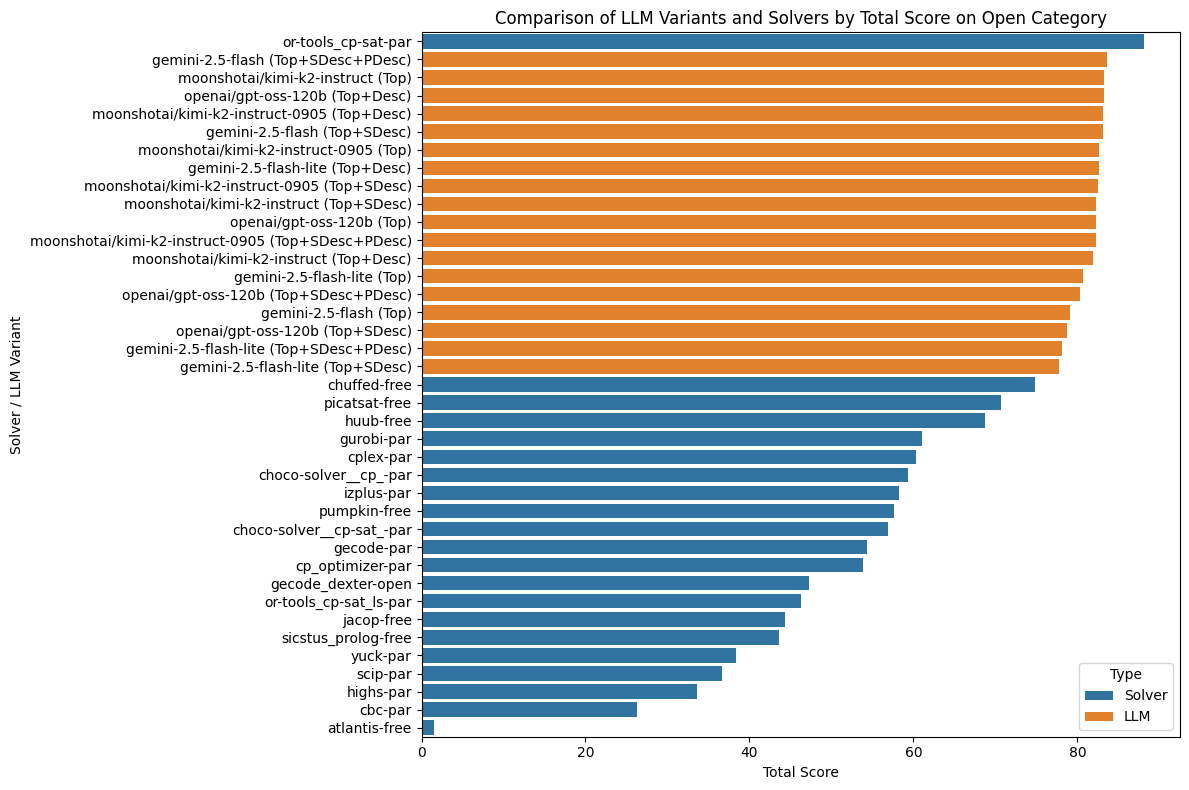

In [26]:
# We plot the comparison
plt.figure(figsize=(12, 8))
sns.barplot(
    data=generalScores_open_df,
    x='TotalScore',
    y='Solver',
    hue='Type'
)
plt.title('Comparison of LLM Variants and Solvers by Total Score on Open Category')
plt.xlabel('Total Score')
plt.ylabel('Solver / LLM Variant')
plt.tight_layout()
plt.show()

## Top 1 Evaluation

In [27]:
# --- Compute Top-1 LLM scores for different variants ---
llmT_top1_summary, llmT_top1_scored = compute_top1_llm_scores(llmT_df, scored_df)
print('Top LLM Top-1 Summary:')
display(llmT_top1_summary)

llmTD_top1_summary, llmTD_top1_scored = compute_top1_llm_scores(llmTD_df, scored_df)
print('Top+Desc LLM Top-1 Summary:')
display(llmTD_top1_summary)

llmTSD_top1_summary, llmTSD_top1_scored = compute_top1_llm_scores(llmTSD_df, scored_df)
print('Top+SDesc LLM Top-1 Summary:')
display(llmTSD_top1_summary)

llmTSDPD_top1_summary, llmTSDPD_top1_scored = compute_top1_llm_scores(llmTSDPD_df, scored_df)
print('Top+SDesc+PDesc LLM Top-1 Summary:')
display(llmTSDPD_top1_summary)

# --- Save all Top-1 LLM scored variants  DataFrame to CSV ---
llmT_top1_summary.to_csv('../data/DFs/top1Scored/llm_Base.csv', index=False)
llmTD_top1_summary.to_csv('../data/DFs/top1Scored/llm_Desc.csv', index=False)
llmTSD_top1_summary.to_csv('../data/DFs/top1Scored/llm_SDesc.csv', index=False)
llmTSDPD_top1_summary.to_csv('../data/DFs/top1Scored/llm_SDescPDesc.csv', index=False)

Top LLM Top-1 Summary:


,provider,model,LLM_Top1_TotalScore,LLM_Top1_AvgScore,InstancesCovered
4,groq,openai/gpt-oss-120b,74.488278,0.744883,100
3,groq,moonshotai/kimi-k2-instruct-0905,71.622810,0.753924,100
2,groq,moonshotai/kimi-k2-instruct,70.939397,0.723871,100
1,gemini,gemini-2.5-flash-lite,70.145187,0.738370,100
0,gemini,gemini-2.5-flash,69.763464,0.742165,98


Top+Desc LLM Top-1 Summary:


,provider,model,LLM_Top1_TotalScore,LLM_Top1_AvgScore,InstancesCovered
3,groq,moonshotai/kimi-k2-instruct-0905,72.605485,0.748510,100
4,groq,openai/gpt-oss-120b,70.740627,0.721843,100
1,gemini,gemini-2.5-flash-lite,69.042851,0.719196,100
2,groq,moonshotai/kimi-k2-instruct,67.554606,0.718666,100
0,gemini,gemini-2.5-flash,49.896660,0.723140,73


Top+SDesc LLM Top-1 Summary:


,provider,model,LLM_Top1_TotalScore,LLM_Top1_AvgScore,InstancesCovered
2,chat,moonshotai/kimi-k2-instruct,76.964375,0.769644,100
3,chat,moonshotai/kimi-k2-instruct-0905,76.964375,0.769644,100
0,chat,gemini-2.5-flash,71.686651,0.716867,100
4,chat,openai/gpt-oss-120b,70.974357,0.716913,100
1,chat,gemini-2.5-flash-lite,54.713809,0.552665,100


Top+SDesc+PDesc LLM Top-1 Summary:


,provider,model,LLM_Top1_TotalScore,LLM_Top1_AvgScore,InstancesCovered
4,chat,openai/gpt-oss-120b,77.260854,0.780413,100
3,chat,moonshotai/kimi-k2-instruct-0905,76.964375,0.769644,100
2,chat,moonshotai/kimi-k2-instruct,74.464375,0.752165,99
0,chat,gemini-2.5-flash,73.551613,0.750527,100
1,chat,gemini-2.5-flash-lite,63.062994,0.630630,100


In [28]:
# Ensure consistent string types
llmTSDPD_top1_scored['problem'] = llmTSDPD_top1_scored['problem'].astype(str)
llmTSDPD_top1_scored['instance'] = llmTSDPD_top1_scored['instance'].astype(str)
scored_df['Problem'] = scored_df['Problem'].astype(str)
scored_df['Instance'] = scored_df['Instance'].astype(str)

# Rows where the merge produced no ComputedScore (NaN)
missing = llmTSDPD_top1_scored[llmTSDPD_top1_scored['ComputedScore'].isna()].copy()
print(f"Total missing scored entries after merge: {len(missing)}")

# Summary by (provider, model)
missing_summary = (
    missing
    .groupby(['provider', 'model'], as_index=False)
    .agg(
        MissingInstances=('instance', 'nunique'),
        MissingRows=('instance', 'size')
    )
    .sort_values('MissingInstances', ascending=False)
)
print("Missing summary by provider/model:")
display(missing_summary)

# Build a lookup of available solvers (as strings) for each
solvers_lookup = (
    scored_df
    .groupby(['Problem', 'Instance'])['Solver']
    .apply(lambda s: sorted(set(map(str, s))))
    .to_dict()
)

if not missing.empty:
    # Add available solvers for context to help debug mismatch causes
    def available_solvers(row):
        key = (row['problem'], row['instance'])
        return solvers_lookup.get(key, [])

    missing['AvailableSolvers'] = missing.apply(available_solvers, axis=1)

    # Show distinct missing entries with useful columns
    display( missing)
else:
    print('No missing computed-score rows found in llm_top1_scored.')

# Show scored instances that the LLM never covered at all
all_instances = set(zip(scored_df['Problem'], scored_df['Instance']))
covered_by_llm = set(zip(llmTSD_top1_scored['problem'], llmTSD_top1_scored['instance']))
not_covered = sorted(list(all_instances - covered_by_llm))
print(f"\nInstances present in scored_df but not covered by any top1 in the LLM data: {len(not_covered)} (showing up to 50)")
for prob, inst in not_covered[:50]:
    print(prob, inst)

Total missing scored entries after merge: 3
Missing summary by provider/model:


,provider,model,MissingInstances,MissingRows
0,chat,gemini-2.5-flash,2,2
1,chat,openai/gpt-oss-120b,1,1


,provider,model,problem,instance,top3_list,top3,Solver,time_seconds,LLMvariant,Problem,Instance,ComputedScore,AvailableSolvers
167,chat,gemini-2.5-flash,products-and-shelves,ps-50-06,"[cp_optimizer-free, or-tools_cp-sat-free, chuf...","cp_optimizer-free, or-tools_cp-sat-free, chuff...",cp_optimizer-free,NaN,Top+SDesc+PDesc,products-and-shelves,ps-50-06,NaN,"[atlantis-free, cbc-free, choco-solver__cp-sat..."
168,chat,gemini-2.5-flash,products-and-shelves,ps-50-09,"[cp_optimizer-free, or-tools_cp-sat-free, chuf...","cp_optimizer-free, or-tools_cp-sat-free, chuff...",cp_optimizer-free,NaN,Top+SDesc+PDesc,products-and-shelves,ps-50-09,NaN,"[atlantis-free, cbc-free, choco-solver__cp-sat..."
416,chat,openai/gpt-oss-120b,cgt,cgt_3_h39_r0.05_s1_3,"[choco-solver__cp_-par, or-tools_cp-sat_ls-fre...","choco-solver__cp_-par, or-tools_cp-sat_ls-free...",choco-solver__cp_-par,NaN,Top+SDesc+PDesc,NaN,NaN,NaN,"[atlantis-free, cbc-free, choco-solver__cp-sat..."



Instances present in scored_df but not covered by any top1 in the LLM data: 0 (showing up to 50)


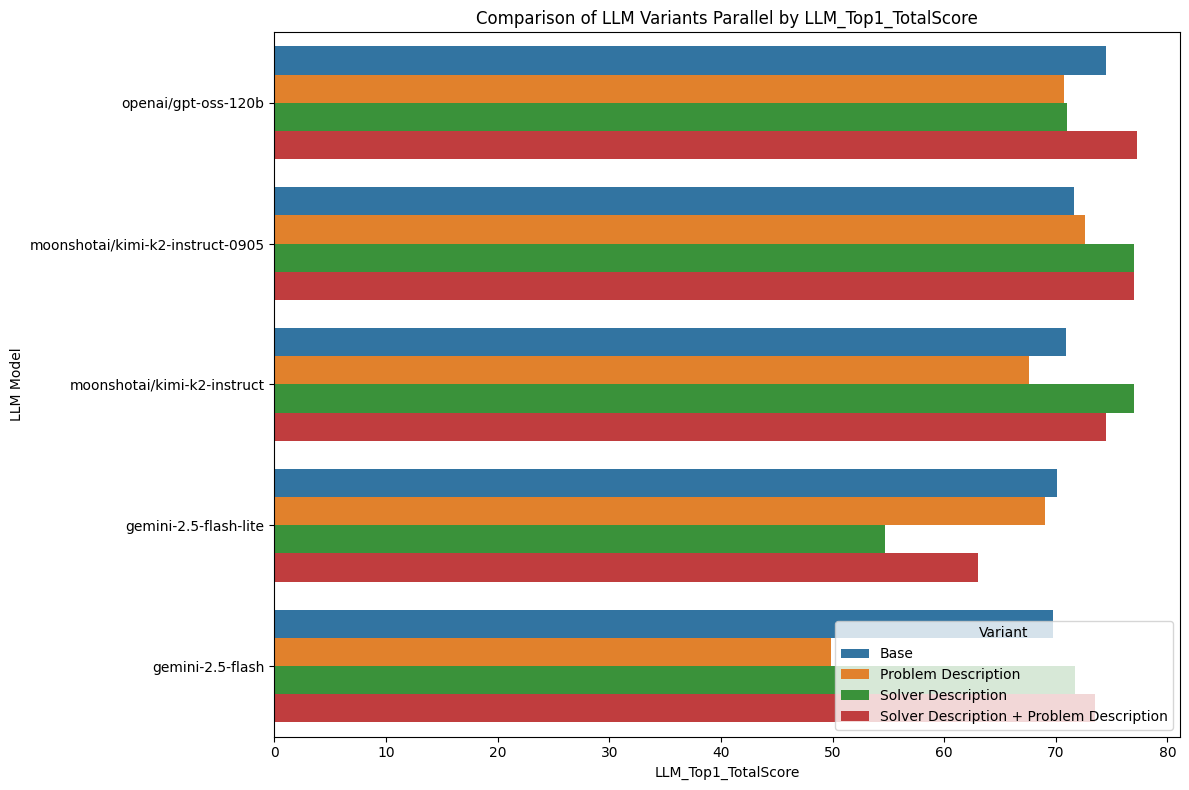

In [29]:
# --- Plot comparison of LLM top1 score variants ---
plot_llm_variant_comparison(
    [llmT_top1_summary, llmTD_top1_summary, llmTSD_top1_summary, llmTSDPD_top1_summary],
    ['Base', 'Problem Description', 'Solver Description', 'Solver Description + Problem Description'],
    'LLM_Top1_TotalScore'
)

In [30]:
# --- compute closed gap for different LLM variants ---
llmT_cg_results = compute_closed_gap(llmT_top1_scored, scored_df)
llmT_cg_df = pd.DataFrame(llmT_cg_results).sort_values('ClosedGap', ascending=False)
print('Top LLM Closed Gap:')
display(llmT_cg_df)

llmTD_cg_results = compute_closed_gap(llmTD_top1_scored, scored_df)
llmTD_cg_df = pd.DataFrame(llmTD_cg_results).sort_values('ClosedGap', ascending=False)
print('Top+Desc LLM Closed Gap:')
display(llmTD_cg_df)

llmTSD_cg_results = compute_closed_gap(llmTSD_top1_scored, scored_df)
llmTSD_cg_df = pd.DataFrame(llmTSD_cg_results).sort_values('ClosedGap', ascending=False)
print('Top+SDesc LLM Closed Gap:')
display(llmTSD_cg_df)

llmTSDPD_cg_results = compute_closed_gap(llmTSDPD_top1_scored, scored_df)
llmTSDPD_cg_df = pd.DataFrame(llmTSDPD_cg_results).sort_values('ClosedGap', ascending=False)
print('Top+SDesc+PDesc LLM Closed Gap:')
display(llmTSDPD_cg_df)

# --- Save all Closed Gap LLM scored variants  DataFrame to CSV ---
os.makedirs('../data/DFs/closedGap', exist_ok=True)
llmT_cg_df.to_csv('../data/DFs/closedGap/llm_Top1.csv', index=False)
llmTD_cg_df.to_csv('../data/DFs/closedGap/llm_Desc_Top1.csv', index=False)
llmTSD_cg_df.to_csv('../data/DFs/closedGap/llm_SDesc_Top1.csv', index=False)
llmTSDPD_cg_df.to_csv('../data/DFs/closedGap/llm_SDescPDesc_Top1.csv', index=False)

Top LLM Closed Gap:


,provider,model,InstancesCovered,AS,SBS,VBS,ClosedGap
4,groq,openai/gpt-oss-120b,100,74.488278,76.964375,89.0,-0.205731
3,groq,moonshotai/kimi-k2-instruct-0905,100,71.622810,76.964375,89.0,-0.443813
0,gemini,gemini-2.5-flash,98,69.763464,75.414375,87.0,-0.487752
2,groq,moonshotai/kimi-k2-instruct,100,70.939397,76.964375,89.0,-0.500595
1,gemini,gemini-2.5-flash-lite,100,70.145187,76.964375,89.0,-0.566584


Top+Desc LLM Closed Gap:


,provider,model,InstancesCovered,AS,SBS,VBS,ClosedGap
3,groq,moonshotai/kimi-k2-instruct-0905,100,72.605485,76.964375,89.00,-0.362166
4,groq,openai/gpt-oss-120b,100,70.740627,76.964375,89.00,-0.517110
1,gemini,gemini-2.5-flash-lite,100,69.042851,76.964375,89.00,-0.658173
2,groq,moonshotai/kimi-k2-instruct,100,67.554606,76.964375,89.00,-0.781826
0,gemini,gemini-2.5-flash,73,49.896660,56.721184,65.25,-0.800172


Top+SDesc LLM Closed Gap:


,provider,model,InstancesCovered,AS,SBS,VBS,ClosedGap
2,chat,moonshotai/kimi-k2-instruct,100,76.964375,76.964375,89.0,0.000000
3,chat,moonshotai/kimi-k2-instruct-0905,100,76.964375,76.964375,89.0,0.000000
0,chat,gemini-2.5-flash,100,71.686651,76.964375,89.0,-0.438509
4,chat,openai/gpt-oss-120b,100,70.974357,76.964375,89.0,-0.497691
1,chat,gemini-2.5-flash-lite,100,54.713809,76.964375,89.0,-1.848725


Top+SDesc+PDesc LLM Closed Gap:


,provider,model,InstancesCovered,AS,SBS,VBS,ClosedGap
4,chat,openai/gpt-oss-120b,100,77.260854,76.964375,89.0,0.024633
3,chat,moonshotai/kimi-k2-instruct-0905,100,76.964375,76.964375,89.0,0.000000
2,chat,moonshotai/kimi-k2-instruct,99,74.464375,75.964375,88.0,-0.124630
0,chat,gemini-2.5-flash,100,73.551613,76.964375,89.0,-0.283555
1,chat,gemini-2.5-flash-lite,100,63.062994,76.964375,89.0,-1.155019


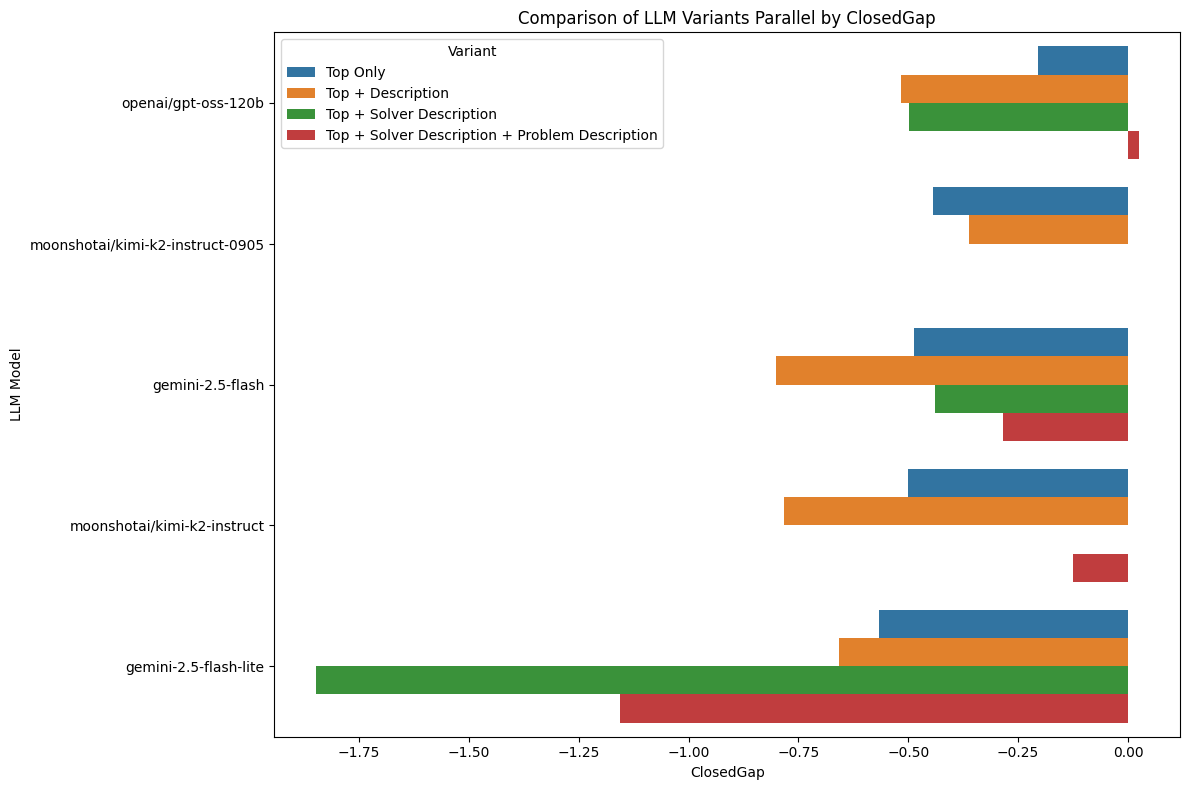

In [31]:
# --- Plot comparison of closedgap in LLM variants ---
plot_llm_variant_comparison(
    [llmT_cg_df, llmTD_cg_df, llmTSD_cg_df, llmTSDPD_cg_df],
    ['Top Only', 'Top + Description', 'Top + Solver Description', 'Top + Solver Description + Problem Description'],
    'ClosedGap'
)

## General Evaluation
We make a general evaluation of model performances against single solver performances, to get a broad view on how good of reults we are getting compared to base solvers.

In [32]:
merged_llm_summary = merge_llm_variants(
    llmT_top1_summary, llmTD_top1_summary, llmTSD_top1_summary, llmTSDPD_top1_summary,
    variant_labels=['Simple', 'Problem Description', 'Solvers Description', 'Solvers Description + Problem Description']
)
print('Merged LLM Summary with Variants:')
display(merged_llm_summary.sort_values('LLM_Top1_TotalScore', ascending=False))

# Save the Merged LLM summary to a .csv file
merged_llm_summary.to_csv('../data/DFs/top1Scored/llm_allVariants.csv', index=False)

Merged LLM Summary with Variants:


,provider,model,LLM_Top1_TotalScore,LLM_Top1_AvgScore,InstancesCovered,Model_Variant
15,chat,openai/gpt-oss-120b,77.260854,0.780413,100,openai/gpt-oss-120b (Solvers Description + Pro...
11,chat,moonshotai/kimi-k2-instruct-0905,76.964375,0.769644,100,moonshotai/kimi-k2-instruct-0905 (Solvers Desc...
10,chat,moonshotai/kimi-k2-instruct,76.964375,0.769644,100,moonshotai/kimi-k2-instruct (Solvers Description)
16,chat,moonshotai/kimi-k2-instruct-0905,76.964375,0.769644,100,moonshotai/kimi-k2-instruct-0905 (Solvers Desc...
0,groq,openai/gpt-oss-120b,74.488278,0.744883,100,openai/gpt-oss-120b (Simple)
17,chat,moonshotai/kimi-k2-instruct,74.464375,0.752165,99,moonshotai/kimi-k2-instruct (Solvers Descripti...
18,chat,gemini-2.5-flash,73.551613,0.750527,100,gemini-2.5-flash (Solvers Description + Proble...
5,groq,moonshotai/kimi-k2-instruct-0905,72.605485,0.748510,100,moonshotai/kimi-k2-instruct-0905 (Problem Desc...
12,chat,gemini-2.5-flash,71.686651,0.716867,100,gemini-2.5-flash (Solvers Description)
1,groq,moonshotai/kimi-k2-instruct-0905,71.622810,0.753924,100,moonshotai/kimi-k2-instruct-0905 (Simple)


In [33]:
# We put together both solver total score and LLM variants total score, to see how LLMs compare to single solvers
llm_totscores = merged_llm_summary.copy()

# Rename LLM_Top1_TotalScore to TotalScore and Model_Variant to Solver
llm_totscores = llm_totscores.rename(columns={'LLM_Top1_TotalScore':'TotalScore', 'Model_Variant': 'Solver'})
# We drop LLM_Top1_AvgScore, InstancesCovered, model and provider columns
llm_totscores = llm_totscores.drop(columns=['LLM_Top1_AvgScore', 'InstancesCovered', 'model', 'provider'])

# We add a column to distinguish solver from LLM variants
llm_totscores['Type'] = 'LLM Variant'
score_solvers_df['Type'] = 'Solver'
frames = [llm_totscores, score_solvers_df]
generalScores = pd.concat(frames)

generalScores_df = pd.DataFrame(generalScores).sort_values('TotalScore', ascending=False)
print('General Scores (LLM variants + Solvers):')
display(generalScores_df)

# --- Save all general scores DataFrame to CSV ---
generalScores_df.to_csv('../data/DFs/solverComparison/generalScores_free.csv', index=False)

General Scores (LLM variants + Solvers):


,TotalScore,Solver,Type
15,77.260854,openai/gpt-oss-120b (Solvers Description + Pro...,LLM Variant
16,76.964375,moonshotai/kimi-k2-instruct-0905 (Solvers Desc...,LLM Variant
11,76.964375,moonshotai/kimi-k2-instruct-0905 (Solvers Desc...,LLM Variant
10,76.964375,moonshotai/kimi-k2-instruct (Solvers Description),LLM Variant
13,76.964375,or-tools_cp-sat-free,Solver
0,74.488278,openai/gpt-oss-120b (Simple),LLM Variant
17,74.464375,moonshotai/kimi-k2-instruct (Solvers Descripti...,LLM Variant
4,74.456334,chuffed-free,Solver
18,73.551613,gemini-2.5-flash (Solvers Description + Proble...,LLM Variant
5,72.605485,moonshotai/kimi-k2-instruct-0905 (Problem Desc...,LLM Variant


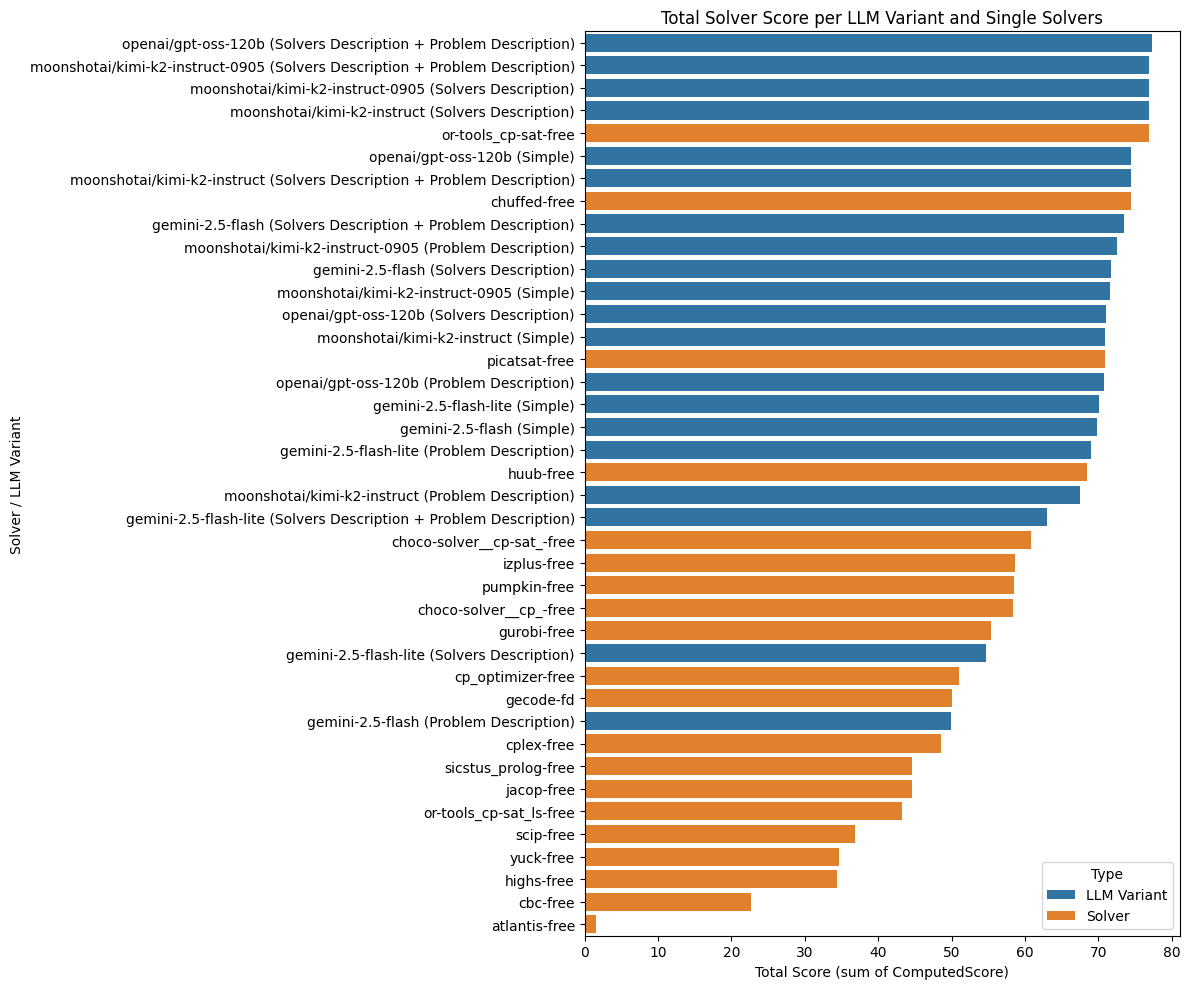

In [34]:
# We plot the merged results, giving different color depending on type column (LLM Variant vs Solver)


plot_df = generalScores_df.sort_values('TotalScore', ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(
    x=plot_df['TotalScore'], 
    y=plot_df['Solver'],
    hue=plot_df['Type']
)
plt.title("Total Solver Score per LLM Variant and Single Solvers")
plt.xlabel("Total Score (sum of ComputedScore)")
plt.ylabel("Solver / LLM Variant")
plt.tight_layout()
plt.show()

## Suggetions Content Analysis
For each LLM, we wanna count how many times each of the solvers has been suggested as the Top 1, or in the Top 3

In [35]:
# For each LLM variant, we count the number of appearences as top 1 for each solver
llm_variant_solver_counts = (
    all_llm_df[all_llm_df['top1'].notnull()]
    .rename(columns={'top1': 'Solver'})
    .groupby(['LLMvariant', 'model', 'Solver'])
    .size()
    .reset_index(name='Top1_Appearances')
)

# Compute number of unique instances covered per (LLMvariant, model)
instance_counts = (
    all_llm_df[all_llm_df['instance'].notnull()]
    .groupby(['LLMvariant', 'model'])['instance']
    .nunique()
    .reset_index(name='InstancesCovered')
)

# Merge and compute percentage of appearances (Top1_Appearances / InstancesCovered)
llm_variant_solver_counts = llm_variant_solver_counts.merge(
    instance_counts, on=['LLMvariant', 'model'], how='left'
)

llm_variant_solver_counts['Top1_Pct'] = (
    llm_variant_solver_counts['Top1_Appearances'] / llm_variant_solver_counts['InstancesCovered']
).fillna(0) * 100

llm_variant_solver_counts['Top1_Pct'] = llm_variant_solver_counts['Top1_Pct'].round(2).astype(str) + "%"

llm_variant_solver_counts = llm_variant_solver_counts.sort_values(['Top1_Appearances', 'Top1_Pct'], ascending=[False, False])
print('LLM Variant Top-1 Appearances per Solver (with percentage of instances covered):')
display(llm_variant_solver_counts.head(40))

# Save to CSV
os.makedirs('../data/DFs/suggestionsAppAnalysis', exist_ok=True)
llm_variant_solver_counts.to_csv('../data/DFs/suggestionsAppAnalysis/SolverAppearances_top1.csv', index=False)

LLM Variant Top-1 Appearances per Solver (with percentage of instances covered):


,LLMvariant,model,Solver,Top1_Appearances,InstancesCovered,Top1_Pct
55,Top+SDesc,moonshotai/kimi-k2-instruct,or-tools_cp-sat-free,100,100,100.0%
76,Top+SDesc+PDesc,moonshotai/kimi-k2-instruct-0905,or-tools_cp-sat-free,100,100,100.0%
57,Top+SDesc,moonshotai/kimi-k2-instruct-0905,or-tools_cp-sat-free,99,100,99.0%
22,Top,openai/gpt-oss-120b,chuffed-free,97,100,97.0%
74,Top+SDesc+PDesc,moonshotai/kimi-k2-instruct,or-tools_cp-sat-free,96,99,96.97%
47,Top+Desc,openai/gpt-oss-120b,chuffed-free,93,100,93.0%
34,Top+Desc,gemini-2.5-flash-lite,or-tools_cp-sat-free,88,100,88.0%
11,Top,gemini-2.5-flash-lite,or-tools_cp-sat-free,86,100,86.0%
67,Top+SDesc+PDesc,gemini-2.5-flash,or-tools_cp-sat-free,85,100,85.0%
51,Top+SDesc,gemini-2.5-flash,or-tools_cp-sat-free,78,100,78.0%


In [36]:
# Now we want to plot how many times each model suggests the SBS solver as top 1
sbs_solver_name = 'or-tools_cp-sat-free'
sbs_appearances = llm_variant_solver_counts[llm_variant_solver_counts['Solver'] == sbs_solver_name]

# We drop the Solver column
sbs_appearances = sbs_appearances.drop(columns=['Solver'])

print(f"SBS Solver ('{sbs_solver_name}') Top-1 Appearances by LLM Variant and Model:")
display(sbs_appearances)

# Save to CSV
sbs_appearances.to_csv('../data/DFs/suggestionsAppAnalysis/SBSAppearances_top1.csv', index=False)


SBS Solver ('or-tools_cp-sat-free') Top-1 Appearances by LLM Variant and Model:


,LLMvariant,model,Top1_Appearances,InstancesCovered,Top1_Pct
55,Top+SDesc,moonshotai/kimi-k2-instruct,100,100,100.0%
76,Top+SDesc+PDesc,moonshotai/kimi-k2-instruct-0905,100,100,100.0%
57,Top+SDesc,moonshotai/kimi-k2-instruct-0905,99,100,99.0%
74,Top+SDesc+PDesc,moonshotai/kimi-k2-instruct,96,99,96.97%
34,Top+Desc,gemini-2.5-flash-lite,88,100,88.0%
11,Top,gemini-2.5-flash-lite,86,100,86.0%
67,Top+SDesc+PDesc,gemini-2.5-flash,85,100,85.0%
51,Top+SDesc,gemini-2.5-flash,78,100,78.0%
81,Top+SDesc+PDesc,openai/gpt-oss-120b,77,100,77.0%
4,Top,gemini-2.5-flash,72,100,72.0%


## Inverse Calculation
We evaluate the problem on which models had worst and bet results

In [37]:
inst_scores_sorted = aggregate_llm_instance_scores(
    llmT_top1_scored, llmTD_top1_scored, llmTSD_top1_scored, llmTSDPD_top1_scored
)

print('Instances sorted (ascending) by combined LLM Top-1 Total Score:')
display(inst_scores_sorted)

# Save to CSV
os.makedirs('../data/DFs/problemAnalysis', exist_ok=True)
inst_scores_sorted.to_csv('../data/DFs/problemAnalysis/InstancePerformance.csv', index=False)

# Show the worst-scored instances (bottom 5)
print('\nBottom 5 instances (least total LLM score):')
display(inst_scores_sorted.head(5))

Instances sorted (ascending) by combined LLM Top-1 Total Score:


,problem,instance,TotalLLMScore,ModelsSeen,PredictionsCount
0,gt-sort,n9_ub30_35.0_BEST,0.0,5,19
1,ihtc-2024-marte,i11,0.0,5,19
2,gt-sort,n13_ub20_50.0_BEST,0.0,5,20
3,tsptw,n100w120.003,0.0,5,20
4,tsptw,n80w180.003,0.0,5,20
...,...,...,...,...,...
95,fbd1,FBDk06,20.0,5,20
96,black-hole,layout_25,20.0,5,20
97,black-hole,layout_27,20.0,5,20
98,EchoSched,12-12-0-1_7,20.0,5,20



Bottom 5 instances (least total LLM score):


,problem,instance,TotalLLMScore,ModelsSeen,PredictionsCount
0,gt-sort,n9_ub30_35.0_BEST,0.0,5,19
1,ihtc-2024-marte,i11,0.0,5,19
2,gt-sort,n13_ub20_50.0_BEST,0.0,5,20
3,tsptw,n100w120.003,0.0,5,20
4,tsptw,n80w180.003,0.0,5,20


In [38]:
# Now we calculate worst performed problmes by aggregating data from the instances contained in inst_scores_sorted
# We merge inst_scores_sorted with scored_df to get problem categories
inst_scores_with_cat = inst_scores_sorted.merge(
    scored_df[['Problem', 'Instance', 'Category']].drop_duplicates(),
    left_on=['problem', 'instance'],
    right_on=['Problem', 'Instance'],
    how='left'
)
# Aggregate total LLM score per problem
problem_scores = inst_scores_with_cat.groupby(['problem', 'Category'], as_index=False).agg(
    ProblemTotalLLMScore=('TotalLLMScore', 'sum'),
    InstanceCount=('instance', 'nunique')
)
# Sort problems by total LLM score ascending
problem_scores_sorted = problem_scores.sort_values('ProblemTotalLLMScore', ascending=True).reset_index(drop=True)
print('Problems sorted (ascending) by combined LLM Top-1 Total Score:')
display(problem_scores_sorted)

# Save the problem scores to CSV
problem_scores_sorted.to_csv('../data/DFs/problemAnalysis/problemsPerformance.csv', index=False)

Problems sorted (ascending) by combined LLM Top-1 Total Score:


,problem,Category,ProblemTotalLLMScore,InstanceCount
0,ihtc-2024-marte,MIN,33.023070,5
1,gt-sort,MIN,37.166667,5
2,cgt,MIN,50.620565,5
3,tsptw,MIN,50.711538,5
4,skill-allocation,MIN,60.835812,5
5,work-task-variation,MIN,61.231344,5
6,groupsplitter,MAX,65.090409,5
7,ihtc-2024-kletzander,MIN,65.725658,5
8,atsp,MIN,68.807248,5
9,mondoku,MIN,70.316667,5


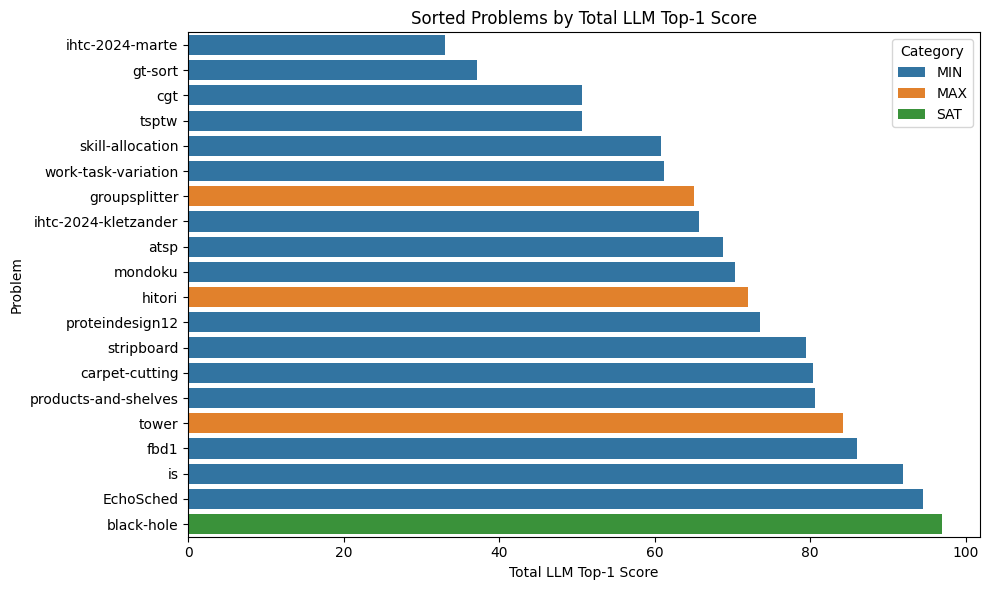

In [39]:
# Now we plot the worst performed problems
plt.figure(figsize=(10, 6))
sns.barplot(
    data=problem_scores_sorted,
    x='ProblemTotalLLMScore',
    y='problem',
    hue='Category'
)
plt.title('Sorted Problems by Total LLM Top-1 Score')
plt.xlabel('Total LLM Top-1 Score')
plt.ylabel('Problem')
plt.tight_layout()
plt.show()

In [40]:
"""GPT 5.0 Suggestions (Solver description + Problem description):
"""
# Convert the pasted GPT-5.0 suggestions into a DataFrame for further operations
gpt_suggestions = [
    {"provider": "gpt-5.0", "model": "suggestions", "problem": "gt-sort", "instance": "n9_ub30_35.0_BEST",
     "top3_list": ["chuffed-free", "izplus-free", "choco-solver__cp_-par"]},
    {"provider": "gpt-5.0", "model": "suggestions", "problem": "gt-sort", "instance": "n13_ub20_50.0_BEST",
     "top3_list": ["chuffed-free", "choco-solver__cp_-par", "cp_optimizer-free"]},
    {"provider": "gpt-5.0", "model": "suggestions", "problem": "ihtc-2024-marte", "instance": "i11",
     "top3_list": ["chuffed-free", "cp_optimizer-free", "or-tools_cp-sat-free"]},
    {"provider": "gpt-5.0", "model": "suggestions", "problem": "ihtc-2024-marte", "instance": "i14",
     "top3_list": ["or-tools_cp-sat-free", "chuffed-free", "cp_optimizer-free"]},
    {"provider": "gpt-5.0", "model": "suggestions", "problem": "tsptw", "instance": "n80w180.003",
     "top3_list": ["chuffed-free", "or-tools_cp-sat-free", "cp_optimizer-free"]},
]

gpt_df = pd.DataFrame(gpt_suggestions)
# add convenient derived columns similar to ResultsFlattener output
gpt_df["top3"] = gpt_df["top3_list"].apply(lambda L: ", ".join(L) if isinstance(L, (list, tuple)) else L)
gpt_df["top1"] = gpt_df["top3_list"].apply(lambda L: L[0] if isinstance(L, (list, tuple)) and L else None)
gpt_df["time_seconds"] = None

display(gpt_df)

,provider,model,problem,instance,top3_list,top3,top1,time_seconds
0,gpt-5.0,suggestions,gt-sort,n9_ub30_35.0_BEST,"[chuffed-free, izplus-free, choco-solver__cp_-...","chuffed-free, izplus-free, choco-solver__cp_-par",chuffed-free,None
1,gpt-5.0,suggestions,gt-sort,n13_ub20_50.0_BEST,"[chuffed-free, choco-solver__cp_-par, cp_optim...","chuffed-free, choco-solver__cp_-par, cp_optimi...",chuffed-free,None
2,gpt-5.0,suggestions,ihtc-2024-marte,i11,"[chuffed-free, cp_optimizer-free, or-tools_cp-...","chuffed-free, cp_optimizer-free, or-tools_cp-s...",chuffed-free,None
3,gpt-5.0,suggestions,ihtc-2024-marte,i14,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,None
4,gpt-5.0,suggestions,tsptw,n80w180.003,"[chuffed-free, or-tools_cp-sat-free, cp_optimi...","chuffed-free, or-tools_cp-sat-free, cp_optimiz...",chuffed-free,None


In [41]:
# Add score columns to the original gpt_df so scores appear inline instead of only in separate tables

# Build a lookup from scored_df for quick access
score_map = scored_df.set_index(['Problem', 'Instance', 'Solver'])['ComputedScore'].to_dict()

def lookup_score(problem, instance, solver):
    if pd.isna(solver):
        return 0.0
    return float(score_map.get((str(problem), str(instance), str(solver)), 0.0))

# Top-1 score column
gpt_df['Top1_Score'] = gpt_df.apply(lambda r: lookup_score(r['problem'], r['instance'], r['top1']) if pd.notnull(r.get('top1')) else 0.0, axis=1)

# Top-3 scores as a list and best-of-top3
def top3_scores_list(row):
    L = row.get('top3_list')
    if not isinstance(L, (list, tuple)):
        return []
    return [lookup_score(row['problem'], row['instance'], s) for s in L]

gpt_df['Top3_Scores'] = gpt_df.apply(top3_scores_list, axis=1)
gpt_df['Top3_BestScore'] = gpt_df['Top3_Scores'].apply(lambda lst: max(lst) if lst else 0.0)

# We drop useless columns
gpt_df = gpt_df.drop(columns=['top3_list', 'model', 'time_seconds', 'provider'])

# Display augmented original table
print("GPT suggestions with inline scores:")
display(gpt_df)

# Save the augmented GPT suggestions to CSV
os.makedirs('../data/DFs/scoredSuggestions', exist_ok=True)
gpt_df.to_csv('../data/DFs/scoredSuggestions/gpt5_scored.csv', index=False)


GPT suggestions with inline scores:


,problem,instance,top3,top1,Top1_Score,Top3_Scores,Top3_BestScore
0,gt-sort,n9_ub30_35.0_BEST,"chuffed-free, izplus-free, choco-solver__cp_-par",chuffed-free,0.0,"[0.0, 0.0, 0.0]",0.000000
1,gt-sort,n13_ub20_50.0_BEST,"chuffed-free, choco-solver__cp_-par, cp_optimi...",chuffed-free,0.0,"[0.0, 0.0, 0.0]",0.000000
2,ihtc-2024-marte,i11,"chuffed-free, cp_optimizer-free, or-tools_cp-s...",chuffed-free,0.0,"[0.0, 0.0, 0.0]",0.000000
3,ihtc-2024-marte,i14,"or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,0.0,"[0.0, 0.0, 0.6492934348319805]",0.649293
4,tsptw,n80w180.003,"chuffed-free, or-tools_cp-sat-free, cp_optimiz...",chuffed-free,0.0,"[0.0, 0.0, 0.0]",0.000000
